In [1]:
import pandas as pd

# Load the Excel file
file_path = "/Users/juliusschulz/Downloads/data_finance_assignment.xlsx"

# Read all sheets into a dictionary of DataFrames
dfs = pd.read_excel(file_path, sheet_name=None)

# Display sheet names
print("Sheets loaded:", dfs.keys())

# Access a specific sheet as a DataFrame (e.g., first sheet)
first_sheet_name = list(dfs.keys())[0]
df_first = dfs[first_sheet_name]

# Display the first few rows of the first sheet
print(df_first.head())


Sheets loaded: dict_keys(['FX_rate', 'Inflation_Rates', 'GDP', 'Interest_Rates', 'ConsumerPriceIndex'])
       DATE:  CURRENCY=CHF/EUR:  Unnamed: 2
0 1999-01-04           0.618506      1.6168
1 1999-01-05           0.620232      1.6123
2 1999-01-06           0.620501      1.6116
3 1999-01-07           0.618620      1.6165
4 1999-01-08           0.619655      1.6138


In [2]:
for sheet_name, df in dfs.items():
    print(f"Sheet: {sheet_name}")
    print(df.head(), "\n")  # Print first 5 rows of each sheet


Sheet: FX_rate
       DATE:  CURRENCY=CHF/EUR:  Unnamed: 2
0 1999-01-04           0.618506      1.6168
1 1999-01-05           0.620232      1.6123
2 1999-01-06           0.620501      1.6116
3 1999-01-07           0.618620      1.6165
4 1999-01-08           0.619655      1.6138 

Sheet: Inflation_Rates
   Year  Inflation, consumer prices (annual %)  \
0  1960                               1.438795   
1  1961                               1.845398   
2  1962                               4.315993   
3  1963                               3.440213   
4  1964                               3.080557   

                                         Data Source  \
0                                  Last Updated Date   
1  https://data.worldbank.org/indicator/FP.CPI.TO...   
2                                                NaN   
3                                       Country Name   
4                                       Country Code   

  World Development Indicators  
0          2025-01-28 00:

In [3]:
# Keep only the first two columns for each sheet
dfs = {sheet: df.iloc[:, :2] for sheet, df in dfs.items()}

# Display the first few rows of each modified sheet
for sheet, df in dfs.items():
    print(f"Sheet: {sheet}")
    print(df.head(), "\n")


Sheet: FX_rate
       DATE:  CURRENCY=CHF/EUR:
0 1999-01-04           0.618506
1 1999-01-05           0.620232
2 1999-01-06           0.620501
3 1999-01-07           0.618620
4 1999-01-08           0.619655 

Sheet: Inflation_Rates
   Year  Inflation, consumer prices (annual %)
0  1960                               1.438795
1  1961                               1.845398
2  1962                               4.315993
3  1963                               3.440213
4  1964                               3.080557 

Sheet: GDP
   Year  GDP (constant 2015 US$)
0  1960             2.126190e+11
1  1961             2.298596e+11
2  1962             2.408697e+11
3  1963             2.526222e+11
4  1964             2.659009e+11 

Sheet: Interest_Rates
       Datum  Interest Rates
0 2024-12-12          0.0050
1 2024-09-26          0.0100
2 2024-06-20          0.0125
3 2024-03-21          0.0150
4 2023-06-23          0.0175 

Sheet: ConsumerPriceIndex
      Year  ConsumerPriceIndex
0  2025-01        

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert date columns to datetime
dfs["FX_rate"].rename(columns={"DATE:": "Date"}, inplace=True)
dfs["FX_rate"]["Date"] = pd.to_datetime(dfs["FX_rate"]["Date"])

dfs["Inflation_Rates"].rename(columns={"Year": "Date"}, inplace=True)
dfs["Inflation_Rates"]["Date"] = pd.to_datetime(dfs["Inflation_Rates"]["Date"].astype(str) + "-01-01")

dfs["GDP"].rename(columns={"Year": "Date"}, inplace=True)
dfs["GDP"]["Date"] = pd.to_datetime(dfs["GDP"]["Date"].astype(str) + "-01-01")

dfs["Interest_Rates"].rename(columns={"Datum": "Date"}, inplace=True)
dfs["Interest_Rates"]["Date"] = pd.to_datetime(dfs["Interest_Rates"]["Date"])

dfs["ConsumerPriceIndex"].rename(columns={"Year": "Date"}, inplace=True)
dfs["ConsumerPriceIndex"]["Date"] = pd.to_datetime(dfs["ConsumerPriceIndex"]["Date"])


In [5]:
# Set Date as index for all DataFrames
for key in dfs:
    dfs[key].set_index("Date", inplace=True)

# Resample to daily frequency
daily_index = pd.date_range(start="2000-01-01",  # NOW STARTING FROM 2000
                            end=max(dfs["Interest_Rates"].index.max(), dfs["ConsumerPriceIndex"].index.max()), 
                            freq='D')

# Reindex each dataset to the daily index
for key in dfs:
    dfs[key] = dfs[key].reindex(daily_index)

# Forward-fill event-based data
dfs["Interest_Rates"].ffill(inplace=True)
dfs["ConsumerPriceIndex"].ffill(inplace=True)

# Interpolate yearly data for smoother plotting
dfs["Inflation_Rates"].interpolate(inplace=True)
dfs["GDP"].interpolate(inplace=True)

# Merge all data into a single DataFrame
merged_df = pd.concat(dfs.values(), axis=1)
merged_df.columns = dfs.keys()  # Rename columns for clarity

# Rename columns for consistency
merged_df.rename(columns={
    "CURRENCY=CHF/EUR:": "FX_rate",
    "Inflation, consumer prices (annual %)": "Inflation_Rates",
    "GDP (constant 2015 US$)": "GDP",
    "Interest Rates": "Interest_Rates",
    "ConsumerPriceIndex": "CPI"
}, inplace=True)

In [27]:
merged_df['Interest_Rates']*100

2000-01-01    1.75
2000-01-02    1.75
2000-01-03    1.75
2000-01-04    1.75
2000-01-05    1.75
              ... 
2024-12-28    0.50
2024-12-29    0.50
2024-12-30    0.50
2024-12-31    0.50
2025-01-01    0.50
Freq: D, Name: Interest_Rates, Length: 9133, dtype: float64

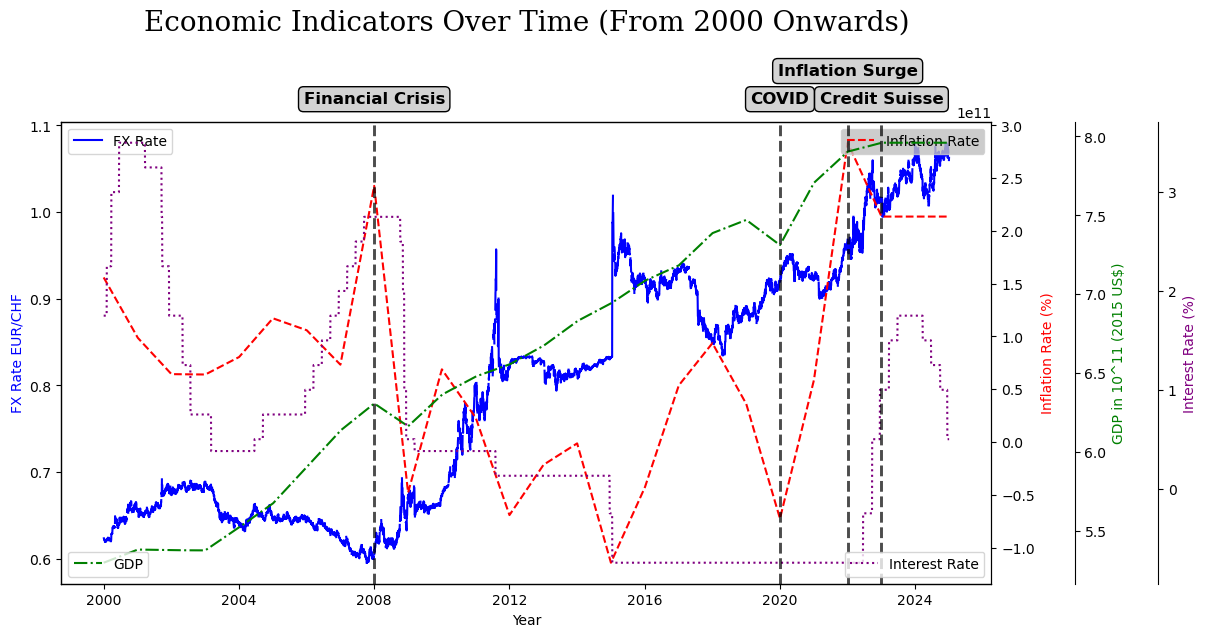

In [347]:
# Filter the data to start from the year 2000 onwards
merged_df = merged_df[merged_df.index >= "2000-01-01"]

# Plot the filtered data
fig, ax1 = plt.subplots(figsize=(12,6))

# FX Rate (Primary y-axis)
ax1.plot(merged_df.index, merged_df["FX_rate"], color='blue', linestyle='-', label="FX Rate")
ax1.set_xlabel("Year")
ax1.set_ylabel("FX Rate EUR/CHF", color='blue')

# Secondary axis for Inflation Rate
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df["Inflation_Rates"], color='red', linestyle='--', label="Inflation Rate")
ax2.set_ylabel("Inflation Rate (%)", color='red')

# Third axis for GDP
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(merged_df.index, merged_df["GDP"], color='green', linestyle='-.', label="GDP")
ax3.set_ylabel("GDP in 10^11 (2015 US$)", color='green')

# Fourth axis for Interest Rates
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(merged_df.index, merged_df["Interest_Rates"]*100, color='purple', linestyle=':', label="Interest Rate")
ax4.set_ylabel("Interest Rate (%)", color='purple')

# Fifth axis for Consumer Price Index
#ax5 = ax1.twinx()
#ax5.spines['right'].set_position(('outward', 180))
#ax5.plot(merged_df.index, merged_df["CPI"], color='orange', linestyle='-', label="CPI")
#ax5.set_ylabel("Consumer Price Index", color='orange')

# Define important years and their corresponding labels
important_events = {
    "2008-01-01": "Financial Crisis",
    "2020-01-01": "COVID",
    "2022-01-01": "Inflation Surge",
    "2023-01-01": "Credit Suisse"
}


# Capture Y-limits **before** adding annotations
y_min, y_max = ax1.get_ylim()

# Manually define Y-positions for each label
manual_y_positions = [y_max * 3.5, y_max * 3.5, y_max * 3.758, y_max * 3.5 ]  # Custom positions for each event

# Convert dictionary keys to a datetime list
important_years = pd.to_datetime(list(important_events.keys()))

# Add vertical lines and manually positioned labels
for i, (year, y_pos) in enumerate(zip(important_years, manual_y_positions)):
    plt.axvline(x=year, color='black', linestyle='--', linewidth=2.1, alpha=0.7)

    # Extract corresponding label
    event_label = important_events[str(year.date())]

    # Use manual Y-positions
    plt.text(year, y_pos, event_label,
             ha='center', va='bottom', fontsize=12, fontweight='bold', 
             rotation=0, bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.3'))


# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right", facecolor='silver')
ax3.legend(loc="lower left")
ax4.legend(loc="lower right")
#ax5.legend(loc="center right")

plt.title("Economic Indicators Over Time (From 2000 Onwards)", y=1.18, fontdict={'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        })
plt.savefig("/Users/juliusschulz/downloads/economic_indicators.jpg", dpi=300, bbox_inches='tight')
plt.show()


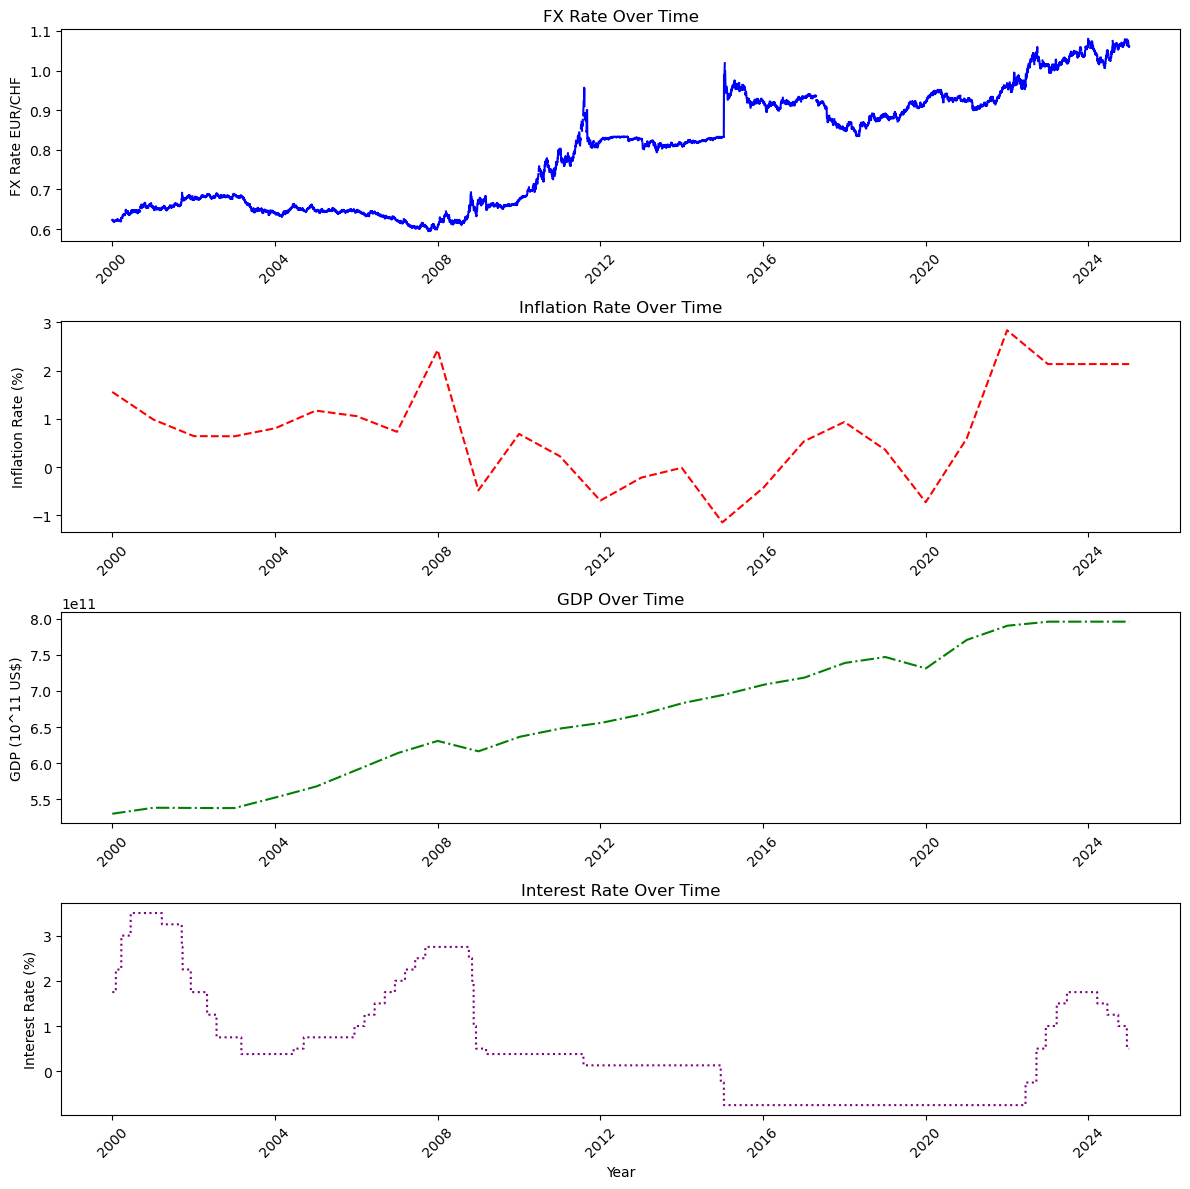

In [85]:
import matplotlib.pyplot as plt

# Create subplots without sharing the x-axis
fig, axes = plt.subplots(4, 1, figsize=(12, 12))

# FX Rate
axes[0].plot(merged_df.index, merged_df["FX_rate"], color='blue', linestyle='-')
axes[0].set_ylabel("FX Rate EUR/CHF")
axes[0].set_title("FX Rate Over Time")
axes[0].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# Inflation Rate
axes[1].plot(merged_df.index, merged_df["Inflation_Rates"], color='red', linestyle='--')
axes[1].set_ylabel("Inflation Rate (%)")
axes[1].set_title("Inflation Rate Over Time")
axes[1].tick_params(axis='x', rotation=45)

# GDP
axes[2].plot(merged_df.index, merged_df["GDP"], color='green', linestyle='-.')
axes[2].set_ylabel("GDP (10^11 US$)")
axes[2].set_title("GDP Over Time")
axes[2].tick_params(axis='x', rotation=45)

# Interest Rates
axes[3].plot(merged_df.index, merged_df["Interest_Rates"] * 100, color='purple', linestyle=':')
axes[3].set_ylabel("Interest Rate (%)")
axes[3].set_xlabel("Year")  # Add x-label only to the last plot
axes[3].set_title("Interest Rate Over Time")
axes[3].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
# Save as JPG
plt.savefig("/Users/juliusschulz/downloads/economic_indicators.jpg", dpi=300, bbox_inches='tight')
plt.show()


In [349]:
merged_df

,FX_rate,Inflation_Rates,GDP,Interest_Rates,CPI,FX_rate_norm,Inflation_Rates_norm,GDP_norm,Interest_Rates_norm
2000-01-01,NaN,1.558529,5.298380e+11,0.0175,NaN,NaN,0.679186,0.000000,0.588235
2000-01-02,NaN,1.556973,5.298608e+11,0.0175,NaN,NaN,0.678795,0.000086,0.588235
2000-01-03,0.623325,1.555417,5.298836e+11,0.0175,NaN,0.058156,0.678404,0.000171,0.588235
2000-01-04,0.622937,1.553861,5.299064e+11,0.0175,NaN,0.057355,0.678013,0.000257,0.588235
2000-01-05,0.622665,1.552305,5.299292e+11,0.0175,NaN,0.056795,0.677622,0.000343,0.588235
...,...,...,...,...,...,...,...,...,...
2024-12-28,NaN,2.135401,7.959781e+11,0.0050,107.8,NaN,0.824167,1.000000,0.294118
2024-12-29,NaN,2.135401,7.959781e+11,0.0050,107.8,NaN,0.824167,1.000000,0.294118
2024-12-30,1.059883,2.135401,7.959781e+11,0.0050,107.8,0.958682,0.824167,1.000000,0.294118
2024-12-31,1.062473,2.135401,7.959781e+11,0.0050,107.8,0.964025,0.824167,1.000000,0.294118


In [353]:
#merged_df.to_csv("/Users/juliusschulz/downloads/raw_data.csv", index=True)